In [61]:
import torch
import numpy as np
import os

file_name = 'mel_output_epoch_98.pth'
output_dir = "/home/kunit17/Her/Data/TrainingOutput/"
input_dir = '/home/kunit17/Her/Data/TrainingData/'
file_path = os.path.join(output_dir, file_name)

mel_output = torch.load(file_path, weights_only=True)
mel_output = mel_output.transpose(0,1).numpy()
mel_input = torch.load(os.path.join((input_dir), '223_mel.pt'), weights_only=True)
mel_input = mel_input.transpose(0,1).numpy()
mask = (mel_output != 0).any(axis=0)
unmasked_mel_input = mel_output[:,mask]
print(mel_output.shape, unmasked_mel_input.shape)
print(mel_output[:,mask])
#print(mel_output[4])


(128, 302) (128, 46)
[[-40.485027 -39.82767  -39.641193 ... -40.78711  -41.117085 -39.86072 ]
 [-36.3744   -35.481365 -35.36972  ... -36.328156 -36.62363  -35.552063]
 [-33.766    -32.952606 -32.53755  ... -33.968563 -34.395607 -32.729946]
 ...
 [-64.829254 -63.314728 -63.615826 ... -67.110565 -67.28382  -63.9819  ]
 [-68.06902  -66.54117  -66.92356  ... -69.78142  -70.21637  -67.42524 ]
 [-77.65274  -77.10383  -77.2078   ... -78.185684 -78.479904 -77.680084]]


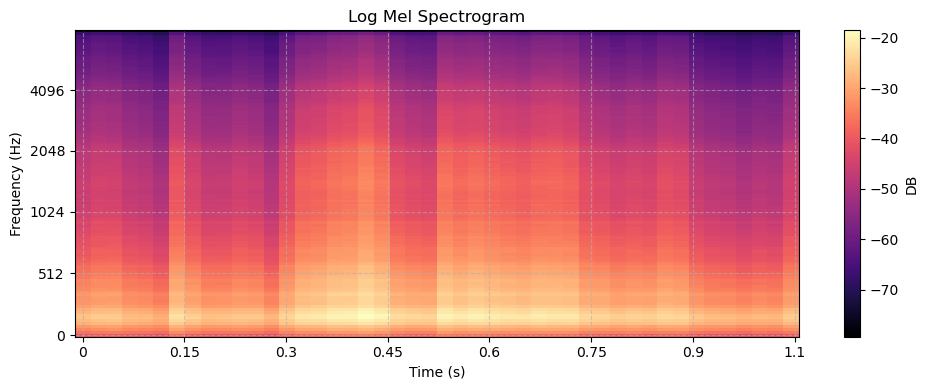

In [62]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

# librosa.display.waveshow(y=signal, sr=sr)
# plt.title('Signal')
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude')
# plt.show()

plt.figure(figsize=(10, 4))
img = librosa.display.specshow(
    unmasked_mel_input,
    n_fft = 1024, 
    sr=22050, 
    hop_length=512, 
    x_axis='time', 
    y_axis='mel', 
    fmax=8000, 
    cmap='magma'
)
plt.colorbar(img, label='DB')  # Add a label to the colorbar
plt.title('Log Mel Spectrogram')
plt.xlabel('Time (s)')  # Label for the x-axis
plt.ylabel('Frequency (Hz)')  # Label for the y-axis
plt.grid(True, linestyle='--', alpha=0.6)  # Optional: add grid for better readability
plt.tight_layout()
plt.show()


Getting reference Mel Specs

In [57]:
import re
import utils
import librosa
import librosa.display
import numpy as np
import torch
import os
import torch.nn.functional as F
import json

n_fft, hop_length, sr = utils.get_audio_params()
# Directory containing .wav files
input_directory = utils.get_audio_samples()
y = {}

# Iterate through all .wav files in the directory - wav names should correspond to text input names (all in numbers)
for file_name in os.listdir(input_directory):
    if file_name.endswith(".wav"):  # Process only .wav files
        file_path = os.path.join(input_directory, file_name)
        
        # Load the audio file and normalize amplitude
        signal, _ = librosa.load(file_path, sr=sr)  # Signal normalized between -1 and 1
        
        # Compute mel spectrogram
        file = os.path.splitext(file_name)[0]
        y[file] = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)
        
        # Convert to log scale (dB)
        log_mel_spectrogram = librosa.power_to_db(y[file], ref=np.max)
        # file = os.path.splitext(file_name)[0]
        # # Store the log-mel spectrogram as a PyTorch tensor
        # y[file] = torch.tensor(log_mel_spectrogram, dtype=torch.float32)
        

In [50]:
print(y['262'])

[[1.1273144e-03 1.0233272e-03 4.0249122e-04 ... 1.6250256e-03
  2.7386474e-03 2.8391110e-03]
 [1.5117052e-03 9.7722898e-04 1.3554974e-03 ... 2.5662945e-03
  5.8793956e-03 4.2107911e-03]
 [1.5116689e-03 1.5317795e-03 2.7447827e-03 ... 3.4304394e-03
  2.8579996e-03 2.0956018e-03]
 ...
 [3.0083442e-08 7.4792524e-08 1.5063031e-07 ... 3.2974579e-06
  6.1864425e-06 3.9961778e-06]
 [3.7189551e-08 6.0752669e-08 8.0652754e-08 ... 1.3553037e-06
  2.5152144e-06 2.3143634e-06]
 [1.2929194e-08 5.2677223e-09 8.0087510e-09 ... 7.6529119e-08
  1.1668574e-07 1.2724624e-07]]


In [ ]:
import re
import utils
import librosa
import librosa.display
import numpy as np
import torch
import os
import torch.nn.functional as F
import json
import soundfile as sf

n_fft, hop_length, sr = utils.get_audio_params()

# Reverse Process
mel_spectrogram_reversed = librosa.db_to_power(unmasked_mel_input, ref=np.max(y['262']))
linear_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram_reversed, sr=sr, n_fft=n_fft)

# Use Griffin-Lim to reconstruct the signal
reconstructed_signal = librosa.griffinlim(linear_spectrogram, hop_length=hop_length, n_iter=64)

# Save reconstructed audio
sf.write('reconstructed_audio.wav', reconstructed_signal, sr)



output_file = 'output.wav'  # Specify the output file name

# Ensure the signal is scaled to the appropriate range for WAV files
# WAV files typically expect 16-bit PCM, so we scale the signal to int16
scaled_signal = (signal * 32767).astype(np.int16)

# Write the WAV file
sf.write(output_file, sr, scaled_signal)

print(f"WAV file written to {output_file}")

In [8]:
import torch
from einops.layers.torch import Rearrange
from einops import rearrange, repeat, reduce, einsum, pack, unpack
batch = 5
print(batch)
times = torch.rand((batch,))
print(times)

5
tensor([0.3293, 0.6662, 0.5751, 0.5560, 0.7564])


In [2]:
import torch
import torch.nn as nn

# Example setup
batch_size = 2
sequence_length = 150
audio_feature_dim = 80
text_vocab_size = 50
text_embedding_dim = 256
transformer_dim = 512

# Inputs
# Audio features: [batch, sequence_length, audio_feature_dim]
audio_features = torch.randn(batch_size, sequence_length, audio_feature_dim)

# Text features (phone sequence indices): [batch, sequence_length]
text_input = torch.randint(0, text_vocab_size, (batch_size, sequence_length))
print(f'Text input before embedding is shape {text_input.shape}')
# Embedding layer for text
text_embedding_layer = nn.Embedding(text_vocab_size, text_embedding_dim)

# # Project audio features to match Transformer dimension
# audio_projection = nn.Linear(audio_feature_dim, transformer_dim)

# # Combine audio and text features
# projection_layer = nn.Linear(text_embedding_dim + transformer_dim, transformer_dim)

# # Forward pass
# # 1. Embed text input: [batch, sequence_length, text_embedding_dim]
text_embeddings = text_embedding_layer(text_input)
print(f'text embeddings after embedding is shape {text_embeddings.shape}')

# # 2. Project audio features: [batch, sequence_length, transformer_dim]
# projected_audio = audio_projection(audio_features)

# # 3. Concatenate along feature dimension: [batch, sequence_length, text_embedding_dim + transformer_dim]
# concatenated = torch.cat([projected_audio, text_embeddings], dim=2)

Text input before embedding is shape torch.Size([2, 150])
text embeddings after embedding is shape torch.Size([2, 150, 256])


In [ ]:
import torch
import math

# Parameters
d_model = 8
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_period = 10000  # For sinusoidal embeddings

# Generate random timesteps (t)
t = torch.rand(batch_size, device=device).view(batch_size, 1, 1)  # Shape: (B, 1, 1)

# Compute freqs (based on d_model)
half = d_model // 2  # Half of the embedding dimension for sin/cos
freqs = torch.exp( #
    -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
).view(1,1,-1).to(device)  
#print(freqs, freqs.shape, freqs.dtype)

# Compute args for sinusoidal embeddings
args = t.squeeze(-1) * freqs  # Squeeze (B, 1, 1) -> (B, 1) and compute (B, half)

print(t, args, args.shape, args.dtype)
sinusoidal_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)  # Shape: (B, d_model)

# Output Results
print("Timesteps (t):")
print(t.squeeze(-1))  # (B, 1)
print("\nFrequency scaling factors (freqs):")
print(freqs)  # (half,)
print("\nSinusoidal Embeddings:")
print(sinusoidal_embedding)  # (B, d_model)
print("Shape:", sinusoidal_embedding.shape)


tensor([[[0.2518]],

        [[0.6599]],

        [[0.9918]],

        [[0.7308]]], device='cuda:0') tensor([1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03], device='cuda:0') tensor([[0.9685, 0.9997, 1.0000, 1.0000],
        [0.7900, 0.9978, 1.0000, 1.0000],
        [0.5472, 0.9951, 1.0000, 1.0000],
        [0.7446, 0.9973, 1.0000, 1.0000]], device='cuda:0') tensor([[2.4915e-01, 2.5178e-02, 2.5180e-03, 2.5181e-04],
        [6.1305e-01, 6.5944e-02, 6.5991e-03, 6.5992e-04],
        [8.3700e-01, 9.9016e-02, 9.9177e-03, 9.9178e-04],
        [6.6749e-01, 7.3018e-02, 7.3083e-03, 7.3083e-04]], device='cuda:0')
